**Use on-demand test objective functions (e.g. bimodal) to help calibrate surrogate functions and acquisition functions**

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
import mbbo.output
from mbbo.output import format_for_submission, output_results_csv, ScenarioResult, TestResults #!pip install -e .
from mbbo.test_gaussian import one_d_test, two_d_test, n_d_test
import mbbo.functions
import mbbo.kernels
from mbbo.functions import FunctionInfo
import mbbo.test_runner
import mbbo.acquisition
%load_ext autoreload
%autoreload 2


In [3]:
random.seed(51)
np.random.seed(51)


In [4]:
#check progress so far

responses = mbbo.functions.responses

for i in range(1, 9):
    _, initial_data = mbbo.functions.load_initial_data(i, True)
    best_initial_data = max(initial_data)
    best = best_initial_data
    for week in range(1, len(responses) + 1):
        response = responses[week - 1][i - 1]
        if response > best_initial_data:
            message = f"Function {i} - week {week} improved on initial values - {response} over {max(initial_data)}"
            if response > best:
                best = response
                message += " (new best)"
            print(message)


Function 2 - week 4 improved on initial values - 0.715790799340666 over 0.6948320857901906 (new best)
Function 2 - week 6 improved on initial values - 0.8097867781489138 over 0.6948320857901906 (new best)
Function 3 - week 3 improved on initial values - -0.005838531351604155 over -0.0251461434112182 (new best)
Function 3 - week 4 improved on initial values - -0.00506242600241439 over -0.0251461434112182 (new best)
Function 3 - week 6 improved on initial values - -0.021754112476429704 over -0.0251461434112182
Function 3 - week 7 improved on initial values - -0.0037570286950206317 over -0.0251461434112182 (new best)
Function 3 - week 8 improved on initial values - -0.003755538834828532 over -0.0251461434112182 (new best)
Function 4 - week 3 improved on initial values - -2.6718044713157307 over -4.025542281908162 (new best)
Function 4 - week 4 improved on initial values - -3.2126105576284227 over -4.025542281908162
Function 4 - week 6 improved on initial values - -2.3290209829198107 over 

In [ ]:
def do_correlations(function_number):
    X, y = mbbo.functions.get_function_data(function_number)

    #1. Simple correlations
    correlations = []
    for i in range(X.shape[1]):
        corr_matrix = np.corrcoef(X[:, i], y)
        corr = corr_matrix[0, 1]  # correlation between dimension i and y
        correlations.append(corr)
    print(f"Simple correlations (function {function_number}):")
    for i, corr in enumerate(correlations):
        print(f"Dimension {i}: correlation with output = {corr:.4f}")

    #2 Coefficients from linear regression
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X, y)

    coeffs = model.coef_
    intercept = model.intercept_
    print("Linear regression:")
    print(f"Coefficients: {coeffs}")
    print(f"Intercept: {intercept}")
    #3 Features importance from random forest
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(random_state=51)
    rf.fit(X, y)

    importances = rf.feature_importances_
    print("Random forest:")
    for i, imp in enumerate(importances):
        print(f"Dimension {i}: importance = {imp:.4f}")
#Function 3 - "(hint: one of the variables may not cause any effects on the person)."
do_correlations(3)
do_correlations(5)

Simple correlations (function 3):
Dimension 0: correlation with output = 0.3102
Dimension 1: correlation with output = 0.2592
Dimension 2: correlation with output = -0.2287
Linear regression:
Coefficients: [ 0.0847793   0.05746307 -0.07743436]
Intercept: -0.11958211390360346
Random forest:
Dimension 0: importance = 0.0696
Dimension 1: importance = 0.1420
Dimension 2: importance = 0.7884
Simple correlations (function 5):
Dimension 0: correlation with output = 0.5308
Dimension 1: correlation with output = 0.1240
Dimension 2: correlation with output = 0.6845
Dimension 3: correlation with output = -0.2014
Linear regression:
Coefficients: [ 656.63530734  549.15712942 1100.42423896  209.24158446]
Intercept: -1014.9717085921343
Random forest:
Dimension 0: importance = 0.1505
Dimension 1: importance = 0.0184
Dimension 2: importance = 0.7465
Dimension 3: importance = 0.0846


In [ ]:
f1_in, f1_out = mbbo.functions.get_function_data(1)
f1_out_scaled = mbbo.functions.scale(1, f1_out) 
for original, scaled in zip(f1_out ,f1_out_scaled):
    print(f"Original: {original:.2E} -> Scaled: {scaled:.4f}")

Original: 1.32E-79 -> Scaled: 0.2262
Original: 1.03E-46 -> Scaled: 0.5592
Original: 7.71E-16 -> Scaled: 0.8717
Original: 3.34E-124 -> Scaled: 0.2253
Original: -3.61E-03 -> Scaled: -1.0000
Original: -2.16E-54 -> Scaled: -0.4814
Original: -2.09E-91 -> Scaled: -0.1067
Original: 2.54E-40 -> Scaled: 0.6239
Original: 3.61E-81 -> Scaled: 0.2104
Original: 6.23E-48 -> Scaled: 0.5468
Original: 0.00E+00 -> Scaled: 0.0000
Original: -1.21E-18 -> Scaled: -0.8433
Original: -2.12E-95 -> Scaled: -0.0663
Original: -8.31E-27 -> Scaled: -0.7607
Original: 1.52E-192 -> Scaled: 0.9172
Original: -1.78E-113 -> Scaled: -0.1167
Original: 5.71E-181 -> Scaled: 0.8000


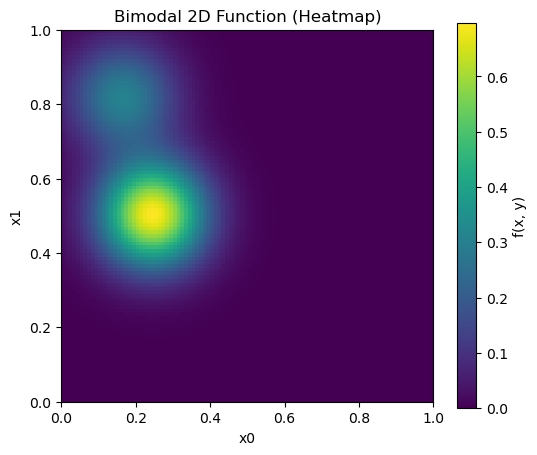

Max from grid search: 0.6961714786707497


In [ ]:
def plot_twod_objective(twod):

    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    X_grid = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)

    y_grid  = twod.call_function(X_grid)
    # Reshape back to (N, N) for plotting
    y_2d = y_grid.reshape(N, N)
    
    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(y_2d, origin='lower', extent=(0,1,0,1), cmap='viridis', aspect='equal')
    plt.colorbar(label='f(x, y)')
    plt.title("Bimodal 2D Function (Heatmap)")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()

    # 3D surface
    #fig = plt.figure(figsize=(8,6))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(X0, X1, y_2d, cmap='viridis', edgecolor='none')
    #ax.set_title("Bimodal 2D Function (Surface Plot)")
    #ax.set_xlabel("x0")
    #ax.set_ylabel("x1")
    #ax.set_zlabel("f(x, y)")
    #plt.show()

    print("Max from grid search:", np.max(y_2d))



testmu1 = [random.random(),random.random()]
testmu2 = [random.random(),random.random()]
testalpha2 = random.uniform(0.3, 0.9)

twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
plot_twod_objective(twod)


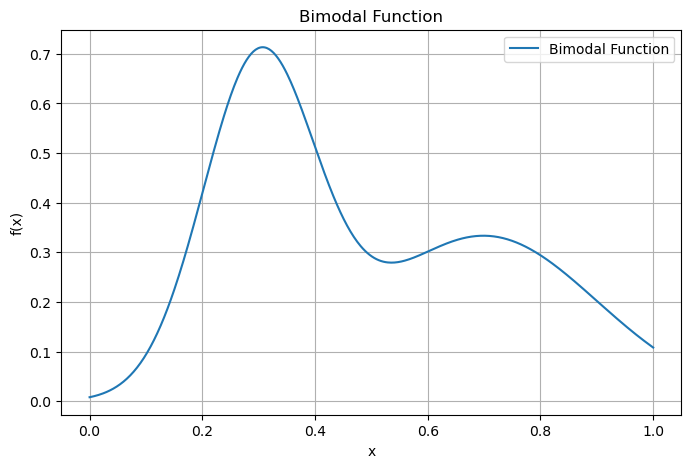

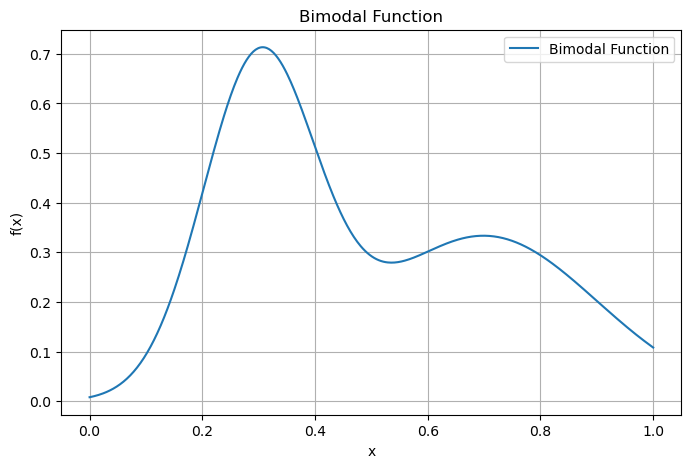

[0.34760895]
[0.34760895]


In [ ]:
#week 4
#pilot test n_d by using it to plot one_d
x = np.linspace(0, 1, 500)
testmu1 = 0.3
testmu2 = 0.7
testalpha1 = 1
testalpha2 = 0.5
testsigma1 = 0.1
testsigma2 = 0.2
oned = one_d_test(sigma1 = testsigma1, sigma2 = testsigma2, mu1=testmu1, mu2=testmu2, alpha1 =testalpha1, alpha2 = testalpha2)
y = oned.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

x = np.linspace(0, 1, 500)
nd = n_d_test(sigma=[testsigma1, testsigma2], mu=[[[testmu1]], [[testmu2]]], alpha=[testalpha1, testalpha2])
y = nd.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

x2 = np.array([0.46])
onedy2 = oned.call_function(x2)
print(onedy2)
ndy2 = nd.call_function(x2)
print(ndy2)




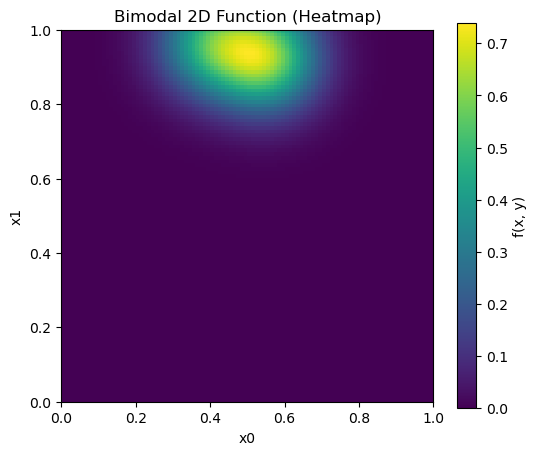

Max from grid search: 0.7384568789275282


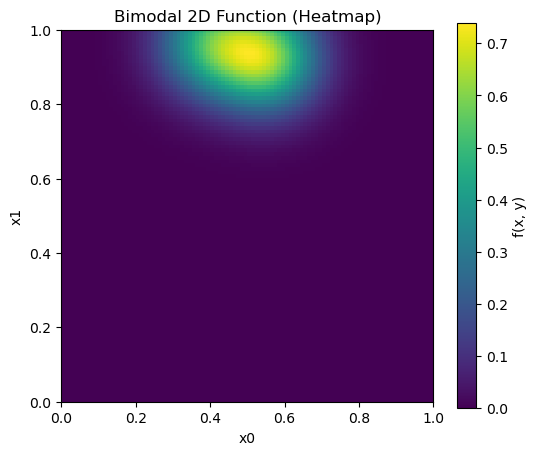

Max from grid search: 0.7384568789275282


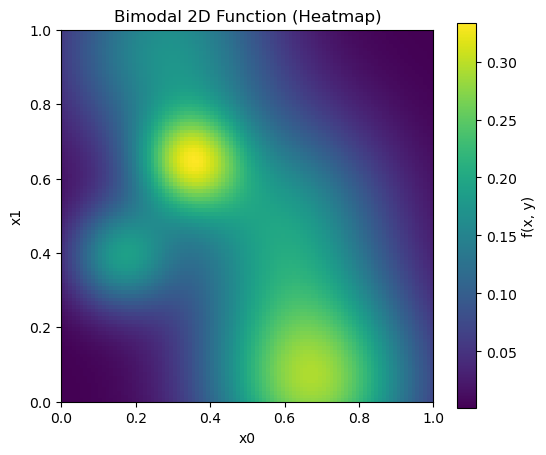

Max from grid search: 0.33303129708859497


In [ ]:
#week 4
#pilot test n_d by using it to plot two_d
testmu1 = [random.random(),random.random()]
testmu2 = [random.random(),random.random()]
testalpha2 = random.uniform(0.3, 0.9)
testalpha1 = 1
twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha1 = 1, alpha2=testalpha2)
plot_twod_objective(twod)

nd = n_d_test(mu = [testmu1, testmu2], sigma=[0.1,0.1], alpha = [testalpha1, testalpha2] )
plot_twod_objective(nd)

# try 5 peaks
mu5 = np.random.rand(5,2)
sigma5 = (0.2, 0.1, 0.2, 0.1, 0.2)
nd5 = n_d_test(mu=mu5, alpha=(1, 0.8,0.6, 0.6, 0.6), sigma = sigma5)
plot_twod_objective(nd5)

In [ ]:

#Experiment with lengthscale 0.1 to 0.5 in steps of 0.05
# and kappa 0.1 to 3 in steps of 0.1

def plot_oned_objective(oned):
    objective_x = np.linspace(0, 1, 500)
    objective_y = oned.call_function(objective_x)
    plt.figure(figsize=(3, 3))
    plt.plot(objective_x, objective_y, label="Objective")
    plt.grid(True)
    plt.show()



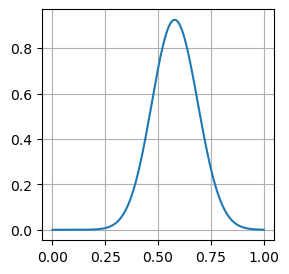

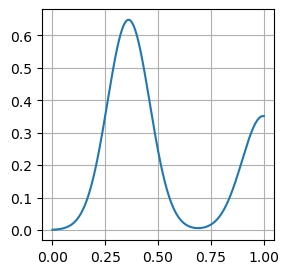

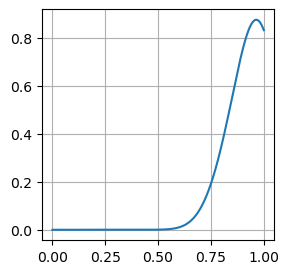

Lengthscale: 0.05
Kappa: 0.1
Kappa: 0.6
Kappa: 1.1
Max iterations reached
Kappa: 1.6
Lengthscale: 0.15000000000000002
Kappa: 0.1
Kappa: 0.6
Kappa: 1.1
Kappa: 1.6


In [ ]:
#ucb_kappa = 3
#rbf_lengthscale = 0.2 # lengthscale parameter
test_functions = []
for i in range(3):
    testmu1 = random.random()
    testmu2 = random.random()
    testalpha2 = random.uniform(0.3, 0.9)
    oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(oned)
    plot_oned_objective(oned) # to see what we're dealing with

results = []
scenario_results = []
for rbf_lengthscale in np.arange(0.05, 0.25, 0.1):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.5):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        
        scenario_description = f"ls={rbf_lengthscale} - k={ucb_kappa}"
        result_list = []
        for oned in test_functions:
            iterations_required = mbbo.test_runner.test_on_oned(rbf_lengthscale, ucb_kappa, oned, 20)
            fn_result.append(iterations_required)
            #print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            result_list.append(iterations_required)
            fn+=1
        results.append(fn_result)
        
        scenario_result = ScenarioResult(scenario_description, result_list)
        scenario_results.append(scenario_result)
test_results = TestResults(scenario_results)

output_results_csv(test_results)

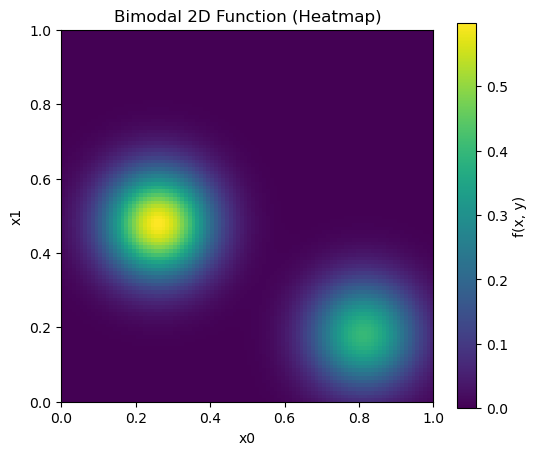

Max from grid search: 0.5981220674774761


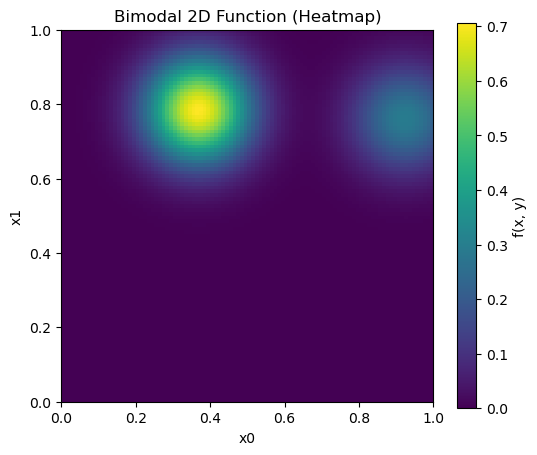

Max from grid search: 0.705606078913391


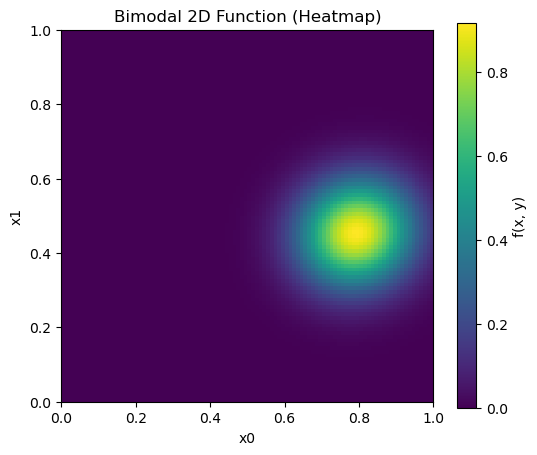

Max from grid search: 0.9170516238851267
Lengthscale: 0.05
Kappa: 0.1
Max iterations reached
Lengthscale: 0.05 Kappa: 0.1 Function: 0 Needed: 0


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max iterations reached
Lengthscale: 0.05 Kappa: 0.1 Function: 1 Needed: 0
Lengthscale: 0.05 Kappa: 0.1 Function: 2 Needed: 8
Kappa: 0.6
Lengthscale: 0.05 Kappa: 0.6 Function: 0 Needed: 10
Max iterations reached
Lengthscale: 0.05 Kappa: 0.6 Function: 1 Needed: 0


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max iterations reached
Lengthscale: 0.05 Kappa: 0.6 Function: 2 Needed: 0
Kappa: 1.1
Lengthscale: 0.05 Kappa: 1.1 Function: 0 Needed: 13
Max iterations reached
Lengthscale: 0.05 Kappa: 1.1 Function: 1 Needed: 0
Lengthscale: 0.05 Kappa: 1.1 Function: 2 Needed: 16
Kappa: 1.6
Lengthscale: 0.05 Kappa: 1.6 Function: 0 Needed: 16
Max iterations reached
Lengthscale: 0.05 Kappa: 1.6 Function: 1 Needed: 0
Lengthscale: 0.05 Kappa: 1.6 Function: 2 Needed: 14
Lengthscale: 0.15000000000000002
Kappa: 0.1
Lengthscale: 0.15000000000000002 Kappa: 0.1 Function: 0 Needed: 12
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 0.1 Function: 1 Needed: 0
Lengthscale: 0.15000000000000002 Kappa: 0.1 Function: 2 Needed: 6
Kappa: 0.6
Max iterations reached
Lengthscale: 0.15000000000000002 Kappa: 0.6 Function: 0 Needed: 0
Lengthscale: 0.15000000000000002 Kappa: 0.6 Function: 1 Needed: 11
Lengthscale: 0.15000000000000002 Kappa: 0.6 Function: 2 Needed: 13
Kappa: 1.1
Lengthscale: 0.15000000000000002 Kapp

KeyboardInterrupt: 

In [ ]:
test_functions = []
for i in range(3): #5
    testmu1 = [random.random(),random.random()]
    testmu2 = [random.random(),random.random()]
    testalpha2 = random.uniform(0.3, 0.9)
    twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(twod)
    plot_twod_objective(twod) # to see what we're dealing with

#test_on_twod(0.15, 0.4, test_functions[0], 20)

results = []
for rbf_lengthscale in np.arange(0.05, 0.5, 0.1):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.5):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        scenario_description = f"ls={rbf_lengthscale} - k={ucb_kappa}"
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        result_list = []
        for twod in test_functions:
            iterations_required = mbbo.test_runner.test_on_twod(rbf_lengthscale, ucb_kappa, twod, 20)
            fn_result.append(iterations_required)
            result_list.append(iterations_required)
            print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

        scenario_result = ScenarioResult(scenario_description, result_list)
        scenario_results.append(scenario_result)
test_results = TestResults(scenario_results)

output_results_csv(test_results)


from the output, lengthscale 0.25 kappa 0.3 was about best for 2d

for 1d, lengthscale 0.15 kappa 0.4


In [ ]:

#tp1 = get_test_profile(1)
#tf1 = tp1.CreateFunctions(1)[0]
#iterations1 = test_on_n_d(tp1, 0.3, 1.00, tf1, 10)

#tp3 = get_test_profile(3)
#tf3 = tp3.CreateFunctions(1)[0]
#iterations3 = test_on_n_d(tp3, 0.3, 1.00, tf3, 10)

for fn in range(1, 9): # for each competition function
    test_profile = mbbo.test_runner.get_test_profile(fn) #create the test profile
    test_functions = test_profile.CreateFunctions() #create gaussian process simulations
    results = []
    kernel_lengthscale = FunctionInfo(fn).kernel_lengthscale # previously trained lengthscales from competition function data
    print("Lengthscale:", kernel_lengthscale)
    
    kernels = mbbo.kernels.make_kernels_for_tests(kernel_lengthscale)
    scenario_results = []
    results_filename = mbbo.output.start_results_csv(len(test_functions), f"Function_{fn}")
    for kernel in kernels:
        for kappa in np.arange(0.1, 1.5, 0.3): # for kappa in range...
            ucb_kappa = round(kappa, 2)
            #print("Kappa:", ucb_kappa)
            result_line = []
            kernelTypeName = kernel.name
            if(len(kernel.params) > 0):
                kernelTypeName += " " + str(kernel.params)
            result_line.append(kernelTypeName)
            result_line.append(kernel_lengthscale)
            result_line.append(ucb_kappa)
            result_list = []
            scenario_description = f"{kernelTypeName} - ls={kernel_lengthscale} - k={ucb_kappa}"
            print(scenario_description)
            
            for test_function in test_functions: # Test the acquisition function configuration on each simulation
                (iterations_required, trained_length_scale) = mbbo.test_runner.test_on_n_d(test_profile, kernel.kernel, ucb_kappa, test_function, 30, n_grid=20)
                result_list.append(iterations_required)
                result_line.append(iterations_required)
                #result_line.append(trained_length_scale)
                #print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            results.append(result_line)
            
            scenario_result = ScenarioResult(scenario_description, result_list)
            scenario_results.append(scenario_result)
            mbbo.output.write_test_result(results_filename, scenario_result)
    test_results = TestResults(scenario_results)
    #print(results)
    mbbo.output.write_best_case_description(results_filename, test_results)

Lengthscale: 0.644
Linear (no noise) - ls=0.644 - k=0.1


In [6]:
# cutdown version that uses sample data instead of the initial random 5 and calls to the objective function, and suggests next point to explore.
# Use that to do week 3 submissions.
# Then, next week, start fitting on functions that are closer to the real ones in terms of local maxima/variance.

def minimize(acquisition_function, initial_x, bounds):
    return optimize.minimize(acquisition_function, x0=initial_x, bounds=bounds)
    
def train_for_suggest(function_info:FunctionInfo, kernel, X, Y):
    noise_assumption = function_info.kernel_params["alpha"]
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption, n_restarts_optimizer=function_info.n_restarts_optimizer)

    model.fit(X, Y)

    return model

def suggest_next(model, acquisition_function, function_num, initial_x = None):
    
    X, Y = mbbo.functions.get_function_data(function_num)
    
    dimensions = X.shape[1]
    bounds = mbbo.test_runner.input_bounds_for_dim(dimensions)
    if(initial_x is None):
        initial_x = mbbo.test_runner.bounds_midpoint(bounds)
    
    # acquisition_function = lambda x: -mbbo.acquisition.UCB(x, model, acquisition_function)
    # optimize.minimize(lambda x: -mbbo.acquisition.UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=bounds)
    result = minimize(acquisition_function, initial_x, bounds)
    trained_length_scale = 0
    if hasattr(model, "kernel_"):
        if(hasattr(model.kernel_, "length_scale")):
            trained_length_scale = model.kernel_.length_scale

    return result.x, trained_length_scale


for i in range(1,9):
    X,y = mbbo.functions.get_function_data(i)
    y = mbbo.functions.scale(i, y) #logarithmic scaling for f1
    X_max = X[np.argmax(y)]
    
    print("Function", i)
    info = FunctionInfo(i)
    if(info.perturb_max_start != 0):
        print("perturb_max_start = ", info.perturb_max_start)
        X_max += info.perturb_max_start
    #kernelWithParams = mbbo.kernels.make_kernel_for_function(info)
    best_kernel, mll = mbbo.kernels.choose_kernel(i)
    model = train_for_suggest(info,best_kernel, X, y)

    acquisition_function = lambda x: -mbbo.acquisition.UCB(x, model, info.ucb_kappa) # using UCB acquisition function for now
    sn, ls = suggest_next(model, acquisition_function, i, initial_x=X_max)
    formatted = format_for_submission(sn)
    print(formatted)
    #print("Trained length scale", ls)

# mbbo.kernels.choose_kernel_3()

Function 1
Function 1
🔹 Kernel: Matern_1.5, MLL: -32.567, Optimized Kernel: 0.569**2 * Matern(length_scale=0.0519, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -32.103, Optimized Kernel: 0.567**2 * Matern(length_scale=0.0518, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RationalQuadratic, MLL: -31.278, Optimized Kernel: 0.562**2 * RationalQuadratic(alpha=1e+05, length_scale=0.05)

✅ Best Kernel: RationalQuadratic with MLL: -31.278


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.798651-0.868125
Function 2
Function 2
🔹 Kernel: Matern_1.5, MLL: -2.308, Optimized Kernel: 0.271**2 * Matern(length_scale=0.418, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -2.333, Optimized Kernel: 0.267**2 * Matern(length_scale=0.392, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RationalQuadratic, MLL: -2.323, Optimized Kernel: 0.263**2 * RationalQuadratic(alpha=1e+05, length_scale=0.355)

✅ Best Kernel: Matern_1.5 with MLL: -2.308
0.747885-0.473503
Function 3
Function 3


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_1.5, MLL: 19.424, Optimized Kernel: 0.0791**2 * Matern(length_scale=40, nu=1.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_2.5, MLL: 19.424, Optimized Kernel: 0.0792**2 * Matern(length_scale=40, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWar

🔹 Kernel: RationalQuadratic, MLL: 19.425, Optimized Kernel: 0.0792**2 * RationalQuadratic(alpha=1e-05, length_scale=40)

✅ Best Kernel: Matern_1.5 with MLL: 19.424
0.499995-0.500000-0.500000
Function 4
Function 4
🔹 Kernel: Matern_1.5, MLL: -129.239, Optimized Kernel: 145**2 * Matern(length_scale=9.77, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -130.839, Optimized Kernel: 51**2 * Matern(length_scale=2.28, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -130.280, Optimized Kernel: 65.7**2 * RationalQuadratic(alpha=0.0235, length_scale=4.16)

✅ Best Kernel: Matern_1.5 with MLL: -129.239
0.395830-0.371021-0.410062-0.404591
Function 5
perturb_max_start =  -0.055
Function 5


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_1.5, MLL: -367.802, Optimized Kernel: 316**2 * Matern(length_scale=0.226, nu=1.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_2.5, MLL: -373.559, Optimized Kernel: 316**2 * Matern(length_scale=0.164, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RationalQuadratic, MLL: -360.681, Optimized Kernel: 316**2 * RationalQuadratic(alpha=0.405, length_scale=0.0889)

✅ Best Kernel: RationalQuadratic with MLL: -360.681


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.253530-0.884504-0.900956-0.824813
Function 6
Function 6
🔹 Kernel: Matern_1.5, MLL: -12.708, Optimized Kernel: 2.76**2 * Matern(length_scale=4.26, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -14.013, Optimized Kernel: 2.62**2 * Matern(length_scale=2.6, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -9.503, Optimized Kernel: 3.08**2 * RationalQuadratic(alpha=0.0447, length_scale=3.74)

✅ Best Kernel: RationalQuadratic with MLL: -9.503
0.364457-0.356583-0.616022-0.799995-0.006197
Function 7
Function 7
🔹 Kernel: Matern_1.5, MLL: -25.293, Optimized Kernel: 0.374**2 * Matern(length_scale=0.474, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -24.751, Optimized Kernel: 0.371**2 * Matern(length_scale=0.444, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RationalQuadratic, MLL: -24.043, Optimized Kernel: 0.366**2 * RationalQuadratic(alpha=1e+05, length_scale=0.395)

✅ Best Kernel: RationalQuadratic with MLL: -24.043


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.104580-0.251129-0.512889-0.201087-0.332013-0.794239
Function 8
Function 8
🔹 Kernel: Matern_1.5, MLL: -24.630, Optimized Kernel: 5.99**2 * Matern(length_scale=8.7, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -20.323, Optimized Kernel: 3.82**2 * Matern(length_scale=4.01, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -17.824, Optimized Kernel: 2.72**2 * RationalQuadratic(alpha=1e+05, length_scale=2.18)

✅ Best Kernel: RationalQuadratic with MLL: -17.824
0.000000-0.000000-0.000000-0.000000-0.999999-0.000000-0.000000-0.999999


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
f=5
info_f = FunctionInfo(f)
X,y = get_function_data(f)
X_max = X[np.argmax(y)]
X_max -= 0.055
sn, ls = suggest_next(info_f.rbf_lengthscale, 30, f, initial_x=X_max)
formatted = format_for_submission(sn)
print(formatted)